# Preprocess OMIP2 Model Output

## Import packages

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import numpy as np
import xarray as xr
import s3fs
import zarr
import util
import warnings
warnings.filterwarnings('ignore')

## Create a new Dask cluster with the Dask Gateway

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [37]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[ClusterReport<name=daskhub.ffedd958cb8f4283acb9e96defff64de, status=RUNNING>]
GatewayCluster<daskhub.ffedd958cb8f4283acb9e96defff64de, status=running>


In [4]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)

cluster.scale(8)
cluster

## Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [5]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.ffedd958cb8f4283acb9e96defff64de/status,


## Open dictionary of OMIP2 simulations
With file lists taken from the ESGF Search Catalog with the following search requirements:
1. On the native grid
2. Have the varaibles:`umo`, `vmo`, `so`, `thetao`, `zos`, `mlotst`, `siconc`, `deptho`, `areacello`
3. At monthly time steps
4. The last 61 years of the simulation

In [6]:
# Load in file of model names and fnames
model_fnames_dict = np.load("models.npy", allow_pickle=True).item()

## Function for writing zarr file to bucket

In [7]:
def write_dataset_to_zarr(ds,sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs = {'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # make file name for variable in simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # write variable to zarr
    %time ds.to_zarr(store=store,mode='w',consolidated=True)
    
    return

## Function for reading from zarr bucket

In [8]:
def read_dataset_from_zarr(sim_name):
    # set path on bucket
    path='WAFFLES/OMIP2/'
    s3_prefix = "s3://" + path
    print(s3_prefix)
    
    # get storage keys
    access_key = !aws configure get aws_access_key_id
    access_key = access_key[0]
    secret_key = !aws configure get aws_secret_access_key
    secret_key = secret_key[0]
    
    # set storage target
    client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}
    target = s3fs.S3FileSystem(anon=False,client_kwargs=client_kwargs)
    
    # file name for simulation
    zarr_file_name = sim_name
    uri = f"{s3_prefix}/{zarr_file_name}"
    
    # get store argument for zarr
    store = zarr.storage.FSStore(uri,client_kwargs=client_kwargs,
                                 key=access_key, secret=secret_key)
    
    # read variable from zarr
    ds=xr.open_zarr(store=store)
    
    return ds

## Preprocess and write subsets of all model data
Open a model and save each variable in the dataset as a `zarr` file in the `waffles` bucket

## Testing below this line
---
Models that **do not** load with `util.load_ds_from_esgf_file_in_model_fnames_dict`
1. CMCC-CM2-SR5 : `OSError: [Errno -68] NetCDF: I/O failure: b'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/CMCC/CMCC-CM2-SR5/omip2/r1i1p1f1/Omon/thetao/gn/v20200226/thetao_Omon_CMCC-CM2-SR5_omip2_r1i1p1f1_gn_195801-201812.nc'`
2. ACCESS-OM2 : Takes prohibatively long time to even load <- allow to run last just to see if it ever loads
3. ACCESS-OM2-025 : Takes prohibatively long time to even load  
``` 
Task exception was never retrieved
future: <Task finished name='Task-8173' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2038> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2047, in wait
    raise AllExit()
distributed.client.AllExit
```
4. EC-Earth3 : `OSError: [Errno -68] NetCDF: I/O failure: b'https://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/OMIP/EC-Earth-Consortium/EC-Earth3/omip2/r1i1p1f1/Omon/mlotst/gn/v20200928/mlotst_Omon_EC-Earth3_omip2_r1i1p1f1_gn_199401-199412.nc'`
5. 

Models that **do not** save to zarr when including 4D variables
1. TaiESM1-TIMCOM2 : `RuntimeError: NetCDF: Authorization failure`
2. NorESM2-LM : `RuntimeError: NetCDF: Authorization failure`
3. MRI-ESM2-0 : `OSError: [Errno -70] NetCDF: DAP server error: b'http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/OMIP/MRI/MRI-ESM2-0/omip1-spunup/r1i1p1f1/Ofx/areacello/gn/v20200406/areacello_Ofx_MRI-ESM2-0_omip1-spunup_r1i1p1f1_gn.nc'`
4. TaiESM1-TIMCOM : `RuntimeError: NetCDF: Authorization failure`
5. FGOALS-f3-L (Failed for 3D vars!) : `RuntimeError: NetCDF: Authorization failure`
6. MIROC6 (Failed for 3D vars!) : `OSError: [Errno -70] NetCDF: DAP server error: b'http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/OMIP/MIROC/MIROC6/omip2/r2i1p1f1/Omon/zos/gn/v20200612/zos_Omon_MIROC6_omip2_r2i1p1f1_gn_189801-199712.nc'`
7. CNRM-CM6-1 : (Failed for 3D vars!) : `RuntimeError: NetCDF: Authorization failure`
8. CMCC-CM2-HR4 : `RuntimeError: NetCDF: Authorization failure`
9. CNRM-CM6-1-HR : `RuntimeError: NetCDF: Authorization failure`

In [9]:
list(model_fnames_dict.keys())

['TaiESM1-TIMCOM2',
 'NorESM2-LM',
 'MRI-ESM2-0',
 'TaiESM1-TIMCOM',
 'CMCC-CM2-SR5',
 'FGOALS-f3-L',
 'ACCESS-OM2',
 'ACCESS-OM2-025',
 'MIROC6',
 'CNRM-CM6-1',
 'EC-Earth3',
 'CMCC-CM2-HR4',
 'CNRM-CM6-1-HR']

In [25]:
sim_name = list(model_fnames_dict.keys())[12]

In [26]:
sim_name

'CNRM-CM6-1-HR'

In [27]:
%%time
# load model from sim_name
ds = util.load_ds_from_esgf_file_in_model_fnames_dict(sim_name,model_fnames_dict)
# ds = util.load_ds_from_esgf_file_in_model_fnames_dict(sim_name, model_fnames_dict,flg_onefile=True)

CPU times: user 22.2 s, sys: 1.45 s, total: 23.7 s
Wall time: 20min 27s


In [28]:
ds

<xarray.Dataset>
Dimensions:        (y: 294, x: 1442, lev: 75, time: 732, vertex: 4, bnds: 2)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(50, 50, 4), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(50, 50, 4), meta=np.ndarray>
  * y              (y) int64 756 757 758 759 760 ... 1045 1046 1047 1048 1049
  * x              (x) int64 0 1 2 3 4 5 6 ... 1436 1437 1438 1439 1440 1441
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
  * lev            (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
  * time           (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    areacello      (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    deptho         (lev, y, x) float32 dask.array<chunksize=(75, 50, 50), meta=np.ndarray>
    mlotst         (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
    so             (time, lev, y, x) float32 dask.array<chunksize=(732, 75, 50, 50), meta=np.ndarray>
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(732, 75, 50, 50), meta=np.ndarray>
    umo            (time, lev, y, x) float32 dask.array<chunksize=(732, 75, 50, 50), meta=np.ndarray>
    vmo            (time, lev, y, x) float32 dask.array<chunksize=(732, 75, 50, 50), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2020-07-10T03:05:43Z
    description:                     Global ocean - sea-ice coupled experimen...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    activity_id:                     OMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    parent_variant_label:            no parent
    history:                         none
    tracking_id:                     hdl:21.14100/51f78e00-7656-49ce-93ad-78f...
    DODS_EXTRA.Unlimited_Dimension:  time
    EXTRA_DIMENSION.axis_nbounds:    2
    EXTRA_DIMENSION.time:            0

In [29]:
list(ds.keys())

['areacello', 'deptho', 'mlotst', 'so', 'thetao', 'umo', 'vmo', 'zos']

In [30]:
# ds_sub = ds[['areacello','deptho','mlotst','zos','so']]
ds_sub = ds[['areacello','deptho','mlotst','zos']]

In [31]:
ds_sub

<xarray.Dataset>
Dimensions:    (y: 294, x: 1442, lev: 75, time: 732)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * y          (y) int64 756 757 758 759 760 761 ... 1045 1046 1047 1048 1049
  * x          (x) int64 0 1 2 3 4 5 6 7 ... 1435 1436 1437 1438 1439 1440 1441
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time       (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
Data variables:
    areacello  (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    deptho     (lev, y, x) float32 dask.array<chunksize=(75, 50, 50), meta=np.ndarray>
    mlotst     (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
    zos        (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                     CF-1.7 CMIP-6.2
    creation_date:                   2020-07-10T03:05:43Z
    description:                     Global ocean - sea-ice coupled experimen...
    title:                           CNRM-CM6-1-HR model output prepared for ...
    activity_id:                     OMIP
    contact:                         contact.cmip@meteo.fr
    ...                              ...
    parent_variant_label:            no parent
    history:                         none
    tracking_id:                     hdl:21.14100/51f78e00-7656-49ce-93ad-78f...
    DODS_EXTRA.Unlimited_Dimension:  time
    EXTRA_DIMENSION.axis_nbounds:    2
    EXTRA_DIMENSION.time:            0

In [32]:
# See what's already in the bucket
target = s3fs.S3FileSystem(anon=False,client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'})
path='WAFFLES/OMIP2/'
target.ls(path)

['WAFFLES/OMIP2/']

In [33]:
write_dataset_to_zarr(ds_sub,sim_name)

s3://WAFFLES/OMIP2/


RuntimeError: NetCDF: Authorization failure

In [34]:
test = read_dataset_from_zarr(sim_name)

s3://WAFFLES/OMIP2/


In [35]:
test

<xarray.Dataset>
Dimensions:    (y: 294, x: 1442, lev: 75, time: 732)
Coordinates:
    lat        (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lon        (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time       (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * x          (x) int64 0 1 2 3 4 5 6 7 ... 1435 1436 1437 1438 1439 1440 1441
  * y          (y) int64 756 757 758 759 760 761 ... 1045 1046 1047 1048 1049
Data variables:
    areacello  (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    deptho     (lev, y, x) float32 dask.array<chunksize=(75, 50, 50), meta=np.ndarray>
    mlotst     (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
    zos        (time, y, x) float32 dask.array<chunksize=(732, 50, 50), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:                cv=6.2.3.0-7-g2019642
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    EXPID:                           CNRM-CM6-1-HR_omip2_r1i1p1f2
    EXTRA_DIMENSION.axis_nbounds:    2
    EXTRA_DIMENSION.time:            0
    ...                              ...
    table_id:                        Ofx
    title:                           CNRM-CM6-1-HR model output prepared for ...
    tracking_id:                     hdl:21.14100/51f78e00-7656-49ce-93ad-78f...
    variable_id:                     areacello
    variant_label:                   r1i1p1f2
    xios_commit:                     1442-shuffle

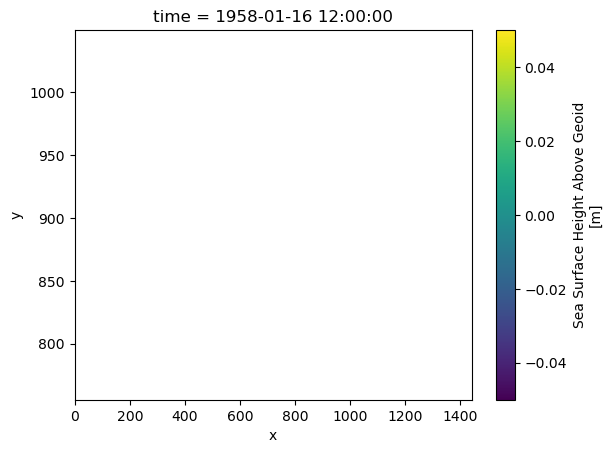

In [36]:
test.zos.isel(time=0).plot(robust=True)

## Some useful, spare code